In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [22]:
def load_HR_data(filename):
    #This function is used to load and clean data
    
    df = pd. read_csv(filename, sep='\s+', names=list(range(54)))
    #obtain the HR data and drop rows with missing data
    #according to the experiemental protocol, Activity type 0 should be removed for analysis
    #df = df[df.loc[:,1]!=0]
    df_sub = df.loc[:,0:2]
    df_sub.dropna(inplace=True)
    
    return df_sub

def signal_reconstruct(df,l_segment=27,l_slide=9):
    #This function is used to reconstruct the signal using k-means clustering
    
    HR = df.loc[:,2].values
    segments = []
    time_frame = []
    
    #divide the signal into small segments
    for pos_start in range(0, len(HR), l_slide):
        pos_end = pos_start + l_segment
        segment = np.copy(HR[pos_start:pos_end])
        
        if len(segment) != l_segment:
            continue
        segments.append(segment)
        time_frame.append(list(range(pos_start, pos_end)))

    #k means clustering to group different signal segments
    num_clusters = len(np.unique(df.loc[:,1]))
    
    clusterer = KMeans(n_clusters=num_clusters)
    clusterer.fit(segments)
    
    centroids = clusterer.cluster_centers_

    #reconstruct the signal by stiching the segments
    n = time_frame[-1][-1]+1
    rec = np.zeros(n)    
    for i in range(len(segments)):
        segment = np.copy(segments[i])
        
        nearest_centroid_idx = clusterer.predict([list(range(l_segment)), segment])
        nearest_centroid = np.copy(centroids[nearest_centroid_idx])
        
        # stitch the reconstructed segments with overlap
        pos = time_frame[i][0]
        rec[pos:pos+l_segment] = nearest_centroid[1]
        
    return rec


def error_anomaly(HR, rec, scale=10):
    # this function is used to detect anomaly based on reconstruction error
    error = pd.DataFrame(rec-HR[0:len(rec)])
    #error stats
    error_std = np.std(error)
    error_avg = np.mean(error)
    #upper and lower boundaries
    upper = error_avg+scale*error_std
    lower = error_avg-scale*error_std
    #identify anomaly 
    upper_anomaly = (np.array(error)>upper.values)
    lower_anomaly = (np.array(error)<lower.values)
    anomaly = upper_anomaly | lower_anomaly
    
    return anomaly
    

def plot_sig_rec_err(HR, rec, df, anomaly, info, subject_num):
    #this function is used to plot the original signal, reconstructed signl, error and anomaly
    error = rec-HR[0:len(rec)]
    #time = df.loc[:,0]
    time_points = list(range(len(rec)))
    plt.plot(time_points, HR[0:len(rec)], label="Original")
    plt.plot(time_points, rec, label="Reconstructed")
    plt.plot(time_points, error, label="Reconstruction Error")
    error = pd.DataFrame(error)
    plt.plot(error[anomaly],marker = '.',color ='r',label='Anomalies')
    plt.title('Subject '+str(subject_num)+'\n'+info[subject_num])
    plt.xlabel('Time Point')
    plt.ylabel('Heart Rate (bpm)')

In [4]:
#subject 101
df_101 = load_HR_data('subject101.dat')
rec_101 = signal_reconstruct(df_101)
HR_101 = df_101.loc[:,2].values
anomaly_101 = error_anomaly(HR_101, rec_101)

In [5]:
#subject 105
df_105 = load_HR_data('subject105.dat')
rec_105 = signal_reconstruct(df_105)
HR_105 = df_105.loc[:,2].values
anomaly_105 = error_anomaly(HR_105, rec_105)

In [6]:
#subject 106
df_106 = load_HR_data('subject106.dat')
rec_106 = signal_reconstruct(df_106)
HR_106 = df_106.loc[:,2].values
anomaly_106 = error_anomaly(HR_106, rec_106)

In [20]:
#subject 108
df_108 = load_HR_data('subject108.dat')
rec_108 = signal_reconstruct(df_108)
HR_108 = df_108.loc[:,2].values
anomaly_108 = error_anomaly(HR_108, rec_108)

In [23]:
#subject info
info={}
info[101] = 'M, 27yrs, Resting HR=75, Max HR=193'
info[105] = 'M, 26yrs, Resting HR=70, Max HR=194'
info[106] = 'M, 26yrs, Resting HR=60, Max HR=194'
info[108] = 'M, 32yrs, Resting HR=66, Max HR=188'


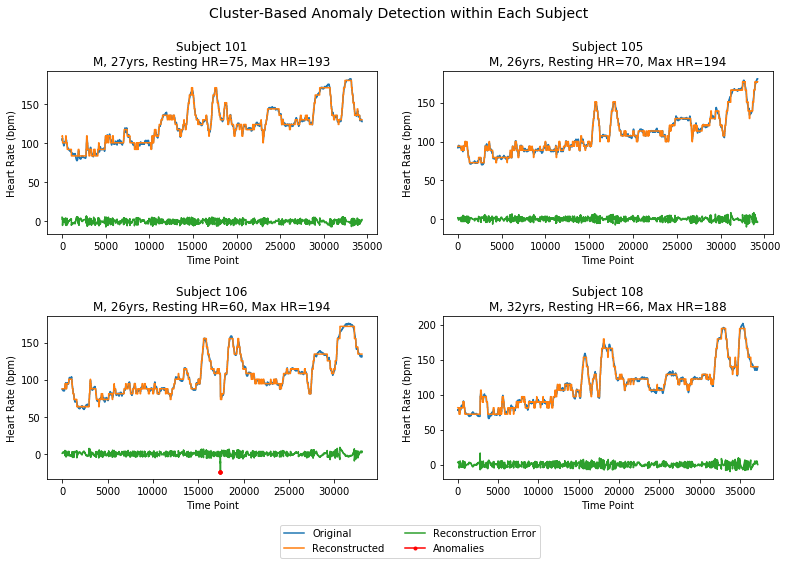

In [24]:
#plotting
fig = plt.figure()
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.subplot(2, 2, 1)
plot_sig_rec_err(HR_101, rec_101, df_101, anomaly_101, info, 101)

plt.subplot(2, 2, 2)
plot_sig_rec_err(HR_105, rec_105, df_105, anomaly_105, info, 105)

plt.subplot(2, 2, 3)
plot_sig_rec_err(HR_106, rec_106, df_106, anomaly_106, info, 106)

plt.subplot(2, 2, 4)
plot_sig_rec_err(HR_108, rec_108, df_108, anomaly_108, info, 108)

fig.set_figheight(7.5)
fig.set_figwidth(13)
plt.suptitle('Cluster-Based Anomaly Detection within Each Subject',fontsize=14,x=0.5,y=1)
plt.legend(loc=9, bbox_to_anchor=(-0.1, -0.25), ncol=2)
plt.show()

In [42]:
# fast DTW
#ref: Stan Salvador, and Philip Chan. 
#"FastDTW: Toward accurate dynamic time warping in linear time and space." 
#Intelligent Data Analysis 11.5 (2007): 561-580.

def dtw_comparison(HR_1, HR_2, df_1, df_2, rec_1, rec_2, anomaly_2, subject1_name, subject2_name):
    distance, path = fastdtw(HR_1,HR_2,dist=euclidean)
    #matching indices for two subjects
    index1,index2=zip(*path)
    HR_1_dtw = [HR_1[i] for i in index1]
    HR_2_dtw = [HR_2[i] for i in index2]
    HR_diff = np.array(HR_2_dtw) - np.array(HR_1_dtw)

    activity_1 = df_1.loc[:,1].values
    activity_2 = df_2.loc[:,1].values

    act_1_dtw = [activity_1[i] for i in index1]
    act_2_dtw = [activity_2[i] for i in index2]
    act_diff = np.array(act_2_dtw) - np.array(act_1_dtw)
    time_points_dtw = np.array(range(len((HR_1_dtw))))
    
    #plotting 
    fig1 = plt.figure()
    plt.plot(HR_1_dtw,'b', label=subject1_name)
    plt.plot(HR_2_dtw,'k', label=subject2_name)

    x=time_points_dtw[act_diff==0]
    y=HR_diff[act_diff==0]
    plt.scatter(x,y, color='g',marker='.', s=0.5,label='difference during same activity')

    #overlay anomalies detected for the second subject
    error_2 = pd.DataFrame(rec_2-HR_2[0:len(rec_2)])
    anomaly_idx_2 = error_2[anomaly_2].index.values
    min_idx = np.where(index2==min(anomaly_idx_2))
    max_idx = np.where(index2==max(anomaly_idx_2))
    plt.axvline(x=min_idx, color='r',lw=0.5)
    plt.axvline(x=max_idx, color='r',lw=0.5, label='anomalies from '+subject2_name)

    plt.xlabel('Warped Time Points', fontsize=12)
    plt.ylabel('Heart Rate',fontsize=12)
    plt.title('Comparison between '+ subject1_name + ' and '+subject2_name+ ' using Dynamic Time Warping', fontsize=14)
    fig1.set_figwidth(14)
    fig1.set_figheight(5)
    plt.legend(fontsize=11)
    plt.show()
    
    return HR_1_dtw, HR_2_dtw

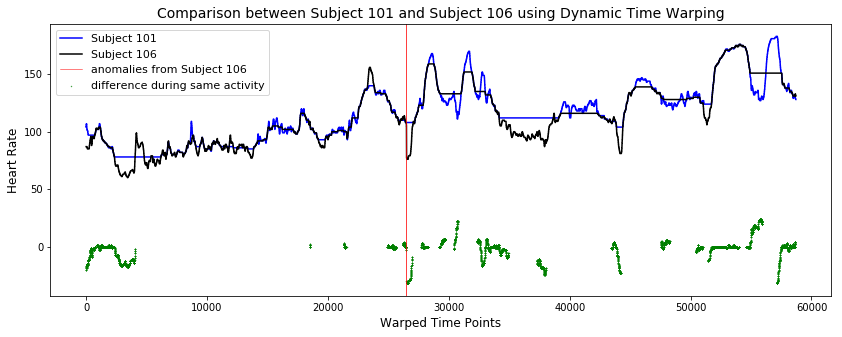

In [43]:
#compare subject 106 to 101
HR_101_dtw, HR_106_dtw = dtw_comparison(HR_101, HR_106, df_101, df_106, rec_101, rec_106, anomaly_106, 'Subject 101', 'Subject 106')

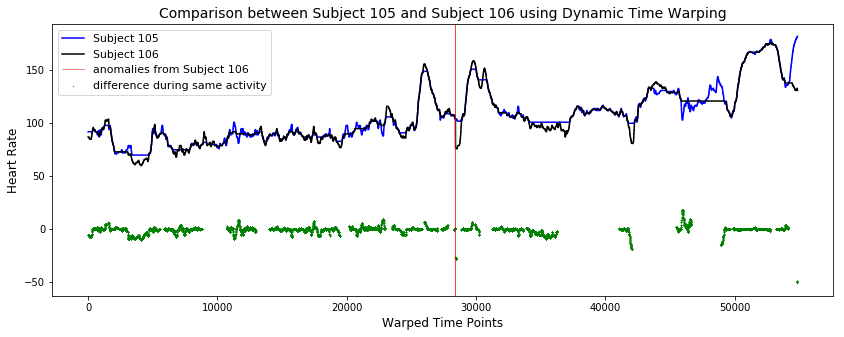

In [44]:
#compare subject 106 to 105
HR_105_dtw, HR_106_dtw = dtw_comparison(HR_105, HR_106, df_105, df_106, rec_105, rec_106, anomaly_106, 'Subject 105', 'Subject 106')

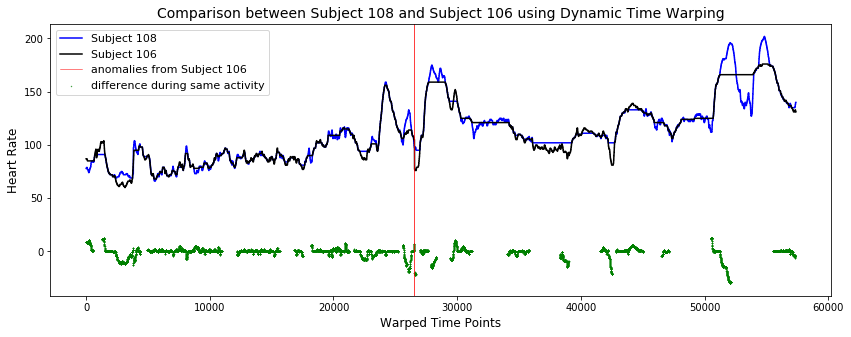

In [45]:
#compare subject 106 to 108
HR_108_dtw, HR_106_dtw = dtw_comparison(HR_108, HR_106, df_108, df_106, rec_108, rec_106, anomaly_106, 'Subject 108', 'Subject 106')